<a href="https://colab.research.google.com/github/nguyen-brat/chat-bot/blob/main/chat_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
from tensorflow.keras.layers import TextVectorization

In [2]:
mask_percent = 0.15 # percent data replace with mask
train_size = 0.8
valid_size = 0.1
test_size = 0.1
max_len = 512 # max len of input feed to neuron network
max_dim = 128 # world embedding dimention
batch_size = 32
num_epochs = 5
n_blocks = 1 # n transformer block
lr = 0.01 # learning rate
n_heads = 8 # n_head in transformer block
drop_rate = 0.1 # drop rate in transformer block
freq_word = 30 # remove all world below freq_word
d_dim = 128 # dimention in FFN layers
vocab_size = 30000

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [4]:
#data = pd.read_csv(r'/content/drive/MyDrive/topical_chat.csv')
data = pd.read_csv(r'topical_chat.csv')
data

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper
...,...,...,...
188373,8628,"Wow, it does not seem like that long. Since I...",Surprised
188374,8628,"I havent seen that episode, I might google it...",Curious to dive deeper
188375,8628,I don't think I have either. That's an insane...,Curious to dive deeper
188376,8628,"I did, my little brother used to love Thomas ...",Happy


In [5]:
data_arranged = [[] for _ in range(8628)]
for i in range(len(data[:])):
  data_arranged[data.iloc[i, 0] - 1].append(data.iloc[i, 1])

In [6]:
def truncate_text(data_arrange):
  list_data = []
  for datas in data_arrange:
    datas = np.array([(x + ' [sep]').split() for x in datas], dtype = object)
    len_data = np.cumsum([len(x) for x in datas])
    filter = np.array(len_data < max_len)
    datas = datas[filter]
    datas = np.concatenate(datas, axis = 0)
    list_data.append(list(datas))
  return list_data

In [7]:
truncated_data = truncate_text(data_arranged)
truncated_data = [' '.join(data) for data in truncated_data]

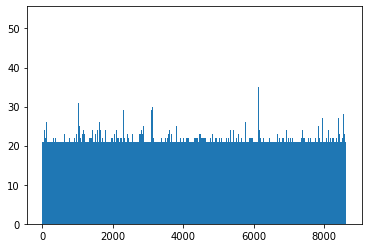

In [8]:
histogram = list(data['conversation_id'])
plt.hist(histogram, bins = list(range(8628)))
plt.show()
#normal conversation roughly 20 turn

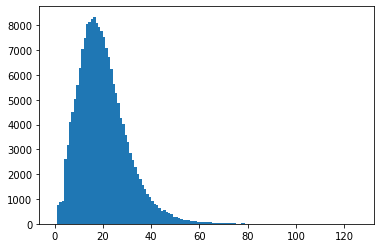

In [9]:
conversation = list(data['message'])
conversation = [len(x.split()) for x in conversation]
plt.hist(conversation, bins = list(range(max(conversation))))
plt.show()
# so the average len of a conversation is arround 18 word

# Preprocess

In [10]:
def custom_data(input):
  lower = tf.strings.lower(input)
  output = tf.strings.regex_replace(lower, '[^a-zA-Z0-9\s]', '')
  return output

In [ ]:
text_vectorize = keras.layers.TextVectorization(
    max_tokens= vocab_size,
    standardize = custom_data,
    output_mode='int',
    output_sequence_length=max_len,
    pad_to_max_tokens = True,
    encoding='utf-8',
)
text_vectorize.adapt(truncated_data)

In [ ]:
def get_mask(array):
  mask = array == 0
  mask = tf.where(mask == True, 0, 1)
  return mask

In [ ]:
def preprocess_dataset(text):
  data = text_vectorize(text)
  mask = get_mask(data)
  data = tf.data.Dataset.from_tensor_slices(data)
  mask = tf.data.Dataset.from_tensor_slices(mask)
  data = tf.data.Dataset.zip((data, mask)).batch(batch_size).shuffle(1000)
  data = data.map(lambda data, mask: (data[:, :-1], data[:, 1:], mask[:, :-1], mask[:, 1:]))
  data = data.prefetch(tf.data.AUTOTUNE)
  return data

In [ ]:
dataset = preprocess_dataset(truncated_data)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Build Model

In [ ]:
class RelativePositionalEncoding(keras.layers.Layer):
  def __init__(self, max_relative, num_head):
    super().__init__()
    self.max_relative = max_relative
    self.num_head = num_head
    w_init = keras.initializers.GlorotUniform()
    with tf.name_scope(self.name):
      self.embedding = tf.Variable(
          initial_value = w_init(shape=(num_head, max_relative * 2 + 1), dtype="float32"), 
          trainable = True
      )
  def call(self, q_len, k_len):
    range_vec_q = tf.range(q_len)
    range_vec_k = tf.range(k_len)
    relative_pos = range_vec_q[:, None] - range_vec_k[None, :]
    relative_pos = tf.clip_by_value(relative_pos, -self.max_relative, self.max_relative)
    relative_pos = relative_pos + self.max_relative
    relative_pos = tf.reshape(tf.tile(relative_pos, [self.num_head, 1]), shape = (self.num_head, q_len, k_len))
    num_head_index = tf.range(self.num_head, dtype = 'int32')
    num_head_index = tf.reshape(tf.tile(num_head_index, [q_len*k_len]), shape = (q_len, k_len, self.num_head))
    num_head_index = tf.transpose(num_head_index, perm = [2, 0, 1]) # shape = num_head, q_len, k_len
    relative_pos = tf.stack([num_head_index, relative_pos], axis = 0) # shape = 2, num_head, q_len, k_len
    relative_pos = tf.transpose(relative_pos, perm = [1, 2, 3, 0]) # shape = num_head, q_len, k_len, 2
    relative_emb = tf.gather_nd(self.embedding, relative_pos) # shape = num_head, q_len, k_len
    return relative_emb

In [ ]:
class MultiheadAttention(keras.layers.Layer):
  def __init__(self, n_heads = 8, dropout_rate = 0.1, use_usual_case = False, use_relative_embed = False, max_relative_pos = 128, **kwargs):
    super(MultiheadAttention, self).__init__()
    self.usual = use_usual_case
    self.n_heads = n_heads
    self.dropout_rate = dropout_rate
    self.use_relative_embed = use_relative_embed
    self.max_relative_pos = max_relative_pos
  def build(self, batch_input_shape):
    self.batch, self.q_time_steps, self.dim = batch_input_shape
    self.q_linear = keras.layers.Conv1D(self.dim * self.n_heads, kernel_size = 1, strides = 1, padding = 'valid', use_bias = False)
    self.k_linear = keras.layers.Conv1D(self.dim * self.n_heads, kernel_size = 1, strides = 1, padding = 'valid', use_bias = False)
    self.v_linear = keras.layers.Conv1D(self.dim * self.n_heads, kernel_size = 1, strides = 1, padding = 'valid', use_bias = False)
    self.linear_out = keras.layers.Conv1D(self.dim, kernel_size = 1, strides = 1, padding = 'valid', use_bias = False)
    self.drop_out = keras.layers.Dropout(self.dropout_rate)
    if self.use_relative_embed:
      self.relative_emb = RelativePositionalEncoding(self.max_relative_pos, self.n_heads)
    super().build(batch_input_shape)
  def mask_attention(self, q, k, v, masking = None, use_usual_case = False):
    q_len = q.shape[1]
    k_len = k.shape[1]
    if masking is None:
      mask = tf.ones(shape = (q_len, k_len))
      if use_usual_case:
        mask = tf.experimental.numpy.tril(mask, 0)
      mask = tf.where(mask == 0, -1e6, 0)
    else:
      mask = tf.reshape(tf.repeat(masking, q_len * self.n_heads, axis = 0), shape = [-1 , q_len, k_len]) # mask shape = [batch * n_heads, q_len, k_len]
      if use_usual_case:
        mask = tf.experimental.numpy.tril(mask, 0)
      mask = tf.where(mask == 0, -1e6, 0)
    normalize = tf.math.sqrt(tf.cast(self.dim, dtype=tf.float32))
    attention = tf.linalg.matmul(q, tf.transpose(k, perm = [0, 2, 1])) / normalize
    attention = attention + mask
    if self.use_relative_embed:
      attention = tf.reshape(attention, shape = [-1, self.n_heads, q_len, k_len])
      attention = self.relative_emb(q_len, k_len) + attention
      attention = tf.reshape(attention, shape = [-1, q_len, k_len])
    norm_attention = tf.nn.softmax(attention, axis = -1)
    output = tf.linalg.matmul(norm_attention, v)
    return output, norm_attention
  def linear_attention(self, input, linear):
    timestep = input.shape[1]
    output = linear(input)
    output = tf.reshape(output, shape = [-1, timestep, self.n_heads, self.dim]) # (batch, timestep, n_heads, dimension)
    output = tf.transpose(output, perm = [0, 2, 1, 3])
    output = tf.reshape(output, shape = [-1 , timestep, self.dim]) # (batch*n_heads, timestep, dimension)
    return output
  def call(self, Q, V, masking = None):
    K = V
    Q = self.linear_attention(Q, self.q_linear)
    K = self.linear_attention(K, self.k_linear)
    V = self.linear_attention(V, self.v_linear)
    output, attention_weight = self.mask_attention(Q, K, V, masking = masking, use_usual_case = self.usual)
    output = tf.reshape(output, shape = [-1, self.n_heads, self.q_time_steps, self.dim]) # (batch, n_heads, q_time_steps, dimension)
    output = tf.transpose(output, perm = [0, 2, 1, 3])
    output = tf.reshape(output, shape = [-1, self.q_time_steps, self.n_heads*self.dim]) # (batch, n_heads, q_time_steps, dimension)
    output = self.linear_out(output)
    output = self.drop_out(output)
    return output, attention_weight

In [16]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [17]:
class FFN(keras.layers.Layer):
  def __init__(self, d_dim = d_dim, drop_rate = drop_rate):
    super().__init__()
    self.d_dim = d_dim
    self.drop = keras.layers.Dropout(drop_rate)
    self.normalize = keras.layers.LayerNormalization(epsilon=1e-6)
  def build(self, batch_input_shape):
    self.dense = keras.layers.Dense(self.d_dim, activation = 'relu')
    self.d_model = keras.layers.Dense(batch_input_shape[-1])
  def call(self, input):
    emb = self.dense(input)
    bottle_neck = self.d_model(emb)
    add = bottle_neck + input
    normalize = self.normalize(add)
    output = self.drop(normalize)
    return output

In [18]:
class transformer_block(keras.layers.Layer):
  def __init__(self, n_heads = n_heads, drop_rate = drop_rate, d_dim = d_dim):
    super(transformer_block, self).__init__()
    self.n_heads = n_heads
    self.drop_rate = drop_rate
    self.MulAttention = MultiheadAttention(n_heads, drop_rate, True, True)
    #self.MulAttention = keras.layers.MultiHeadAttention(num_heads = n_heads, key_dim = d_dim)
    self.ffn = FFN(d_dim, drop_rate)
    self.normalize = keras.layers.LayerNormalization(epsilon=1e-6)
  def call(self, inputs, mask = None):
    #x, attention_weight = self.MulAttention(inputs, mask_q, mask_k)
    x, _ = self.MulAttention(inputs, inputs, mask)
    x = x + inputs
    normalize = self.normalize(x)
    output = self.ffn(normalize)
    return output

In [23]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss_tracker = tf.keras.metrics.Mean(name="loss")
class MaskLanguageModel(keras.Model):
  def __init__(self, d_dim = d_dim, vocab_size = vocab_size ,max_steps = max_len, max_dims = max_dim, n_heads = n_heads, drop_rate = drop_rate, n_blocks = n_blocks):
    super().__init__()
    self.position = PositionalEncoding(max_steps = max_steps, max_dims = max_dims)
    self.transformers = [transformer_block(n_heads = n_heads, drop_rate = drop_rate, d_dim = d_dim) for _ in range(n_blocks)]
    self.dense = keras.layers.Dense(vocab_size)
    self.embed = keras.layers.Embedding(vocab_size, max_dims, input_length = max_steps)
  def call(self, inputs, mask = None):
    embed = self.embed(inputs)
    pos_emb = self.position(embed)
    x = self.transformers[0](pos_emb, mask)
    for block in self.transformers[1:]:
      x = block(x, mask)
    output = self.dense(x)
    output = tf.nn.softmax(output, axis = -1)
    return output
  def train_step(self, data):
    input, label, mask_input, mask_label = data
    with tf.GradientTape() as tape:
      predictions = self(input, mask_input)
      loss = loss_fn(label, predictions, sample_weight = mask_label)
    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    # Compute our own metrics
    loss_tracker.update_state(loss, sample_weight = mask_label)
    # Return a dict mapping metric names to current value
    return {"loss": loss_tracker.result()}

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)
model = MaskLanguageModel(max_steps = max_len - 1)
model.compile(optimizer = keras.optimizers.Adam())
history = model.fit(dataset, epochs = 30, callbacks=[callback])

In [21]:
vocab = text_vectorize.get_vocabulary()
def decode_sentence(array):
  return " ".join([vocab[each] for each in array])

In [47]:
def inference(text):
  text += ' sep'
  index = len(text.split())
  list_prediction = []
  prediction = ''
  while prediction != 'sep':
    encode_text = text_vectorize([text])[:, :-1]
    mask = get_mask(encode_text)
    prediction = model(encode_text, mask)
    prediction = np.argmax(prediction, axis = -1)[0]
    prediction = vocab[prediction[index]]
    text += ' ' + prediction
    list_prediction.append(prediction)
    index += 1
  return ' '.join(list_prediction[:-1])

In [54]:
inference('Hey what\'s up do use Google very often?I really love the company and was surprised to hear that it was founded back in 1998.')

'was and i i like too and i like too i and my is a fan'